1. Imports and Setup

In [1]:
import os
import re
import math
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, classification_report
)
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    get_scheduler,
    DataCollatorWithPadding
)
from tqdm import tqdm

In [2]:
# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


2. Connect Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/My Drive/Colab Notebooks/Assignment/fake_job_postings.csv"
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


3. Build a stronger text field

In [5]:
text_cols = [c for c in [
    'title', 'company_profile', 'description', 'requirements', 'benefits'
] if c in df.columns]

assert len(text_cols) > 0, "No text columns found. Expect at least 'description'."

def join_text(row):
    parts = []
    for c in text_cols:
        val = str(row.get(c, ""))
        if val and val.lower() != "nan":
            parts.append(val)
    return " ".join(parts)

df['__text__'] = df.apply(join_text, axis=1).astype(str)

In [6]:
# Clean minimal noise (optional but safe)
def basic_clean(s: str) -> str:
    s = re.sub(r'\s+', ' ', s)
    s = s.strip()
    return s

df['__text__'] = df['__text__'].apply(basic_clean)

In [7]:
# Labels
if 'fraudulent' not in df.columns:
    raise ValueError("CSV must contain a 'fraudulent' column with 0/1 labels.")
labels = df['fraudulent'].astype(int).tolist()
texts  = df['__text__'].astype(str).tolist()

In [8]:
# Sanity check
assert len(texts) == len(labels), f"Texts ({len(texts)}) and labels ({len(labels)}) must match."

4. Train-test split

In [9]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=SEED, stratify=labels
)

print(f"Train size: {len(train_texts)} | Val size: {len(val_texts)}")
print("Val class counts:", {k:int(v) for k,v in pd.Series(val_labels).value_counts().sort_index().items()})

Train size: 14304 | Val size: 3576
Val class counts: {0: 3403, 1: 173}


5. Tokenizer and Dataset

In [10]:
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
MAX_LEN = 128

class JobDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tok = tokenizer
        self.max_length = max_length
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tok(
            self.texts[idx],
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = JobDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset   = JobDataset(val_texts,   val_labels,   tokenizer, MAX_LEN)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [11]:
# Dynamic padding => faster than padding everything to MAX_LEN
collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

6. DataLoaders

In [12]:
BATCH_SIZE = 32
NUM_WORKERS = 2  # 2-4 is usually stable on Colab
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collator)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collator)

7. Model, Optimizer and Scheduler

In [13]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
).to(device)

LR = 5e-5
WEIGHT_DECAY = 0.01
EPOCHS = 4
ACCUM_STEPS = 2
TOTAL_STEPS = math.ceil(len(train_loader) / ACCUM_STEPS) * EPOCHS
WARMUP_STEPS = int(0.1 * TOTAL_STEPS)  # 10% warmup

optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=TOTAL_STEPS
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


8. Focal Loss

In [14]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=None, gamma=2.5, reduction="mean"):
        super().__init__()
        self.alpha = alpha  # tensor of size [num_classes] or None
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, logits, targets):
        # CE per-sample
        ce = torch.nn.functional.cross_entropy(logits, targets, reduction="none", weight=self.alpha)
        pt = torch.exp(-ce)        # pt = softmax prob for the target class
        loss = ((1 - pt) ** self.gamma) * ce
        if self.reduction == "mean": return loss.mean()
        if self.reduction == "sum":  return loss.sum()
        return loss

In [15]:
# class-balanced weights: alpha_c = N / (K * n_c)
train_counts = pd.Series(train_labels).value_counts().sort_index()  # index 0,1
num_classes = len(train_counts)
N = len(train_labels)
alpha = torch.tensor([N / (num_classes * train_counts.get(i, 1)) for i in range(num_classes)],
                     dtype=torch.float, device=device)

loss_fn = FocalLoss(alpha=alpha, gamma=2.5)  # try 2.0–3.0 if you want to tinker
scaler = GradScaler()

/tmp/ipython-input-3071058314.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


9. Utilities

In [16]:
def evaluate(model, loader, threshold=0.5):
    model.eval()
    total_loss = 0.0
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            for k in ["input_ids", "attention_mask", "labels"]:
                batch[k] = batch[k].to(device)
            outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
            loss = loss_fn(outputs.logits, batch["labels"])
            total_loss += loss.item()
            probs = torch.softmax(outputs.logits, dim=1)[:, 1].detach().cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(batch["labels"].detach().cpu().numpy())
    avg_loss = total_loss / len(loader)

    # Apply threshold to get predictions
    preds = (np.array(all_probs) > threshold).astype(int)
    acc  = accuracy_score(all_labels, preds)
    prec = precision_score(all_labels, preds, average="macro", zero_division=0)
    rec  = recall_score(all_labels, preds, average="macro", zero_division=0)
    f1   = f1_score(all_labels, preds, average="macro", zero_division=0)

    report = classification_report(all_labels, preds, digits=4, zero_division=0)
    # Grab minority-class (1) F1 for early stopping criterion
    f1_fraud = f1_score(all_labels, preds, pos_label=1, average="binary", zero_division=0)
    return {
        "loss": avg_loss, "acc": acc, "prec": prec, "rec": rec, "f1_macro": f1,
        "report": report, "probs": np.array(all_probs), "labels": np.array(all_labels),
        "f1_fraud": f1_fraud
    }

def best_threshold_for_f1(labels, probs):
    # Search thresholds between 0.2 and 0.8 to avoid extremes; step=0.01
    ts = np.linspace(0.2, 0.8, 61)
    best_t, best_f1 = 0.5, -1.0
    for t in ts:
        preds = (probs > t).astype(int)
        f1 = f1_score(labels, preds, pos_label=1, average="binary", zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1

Add Class Weight

In [17]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# compute class weights from your training labels (train_labels must be your full y_train array)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

print("Class Weights:", class_weights)


Class Weights: tensor([ 0.5255, 10.3203], device='cuda:0')


10. Training Loop and Validation

In [18]:
BEST_PATH = "/content/best_distilbert.pt"
best_f1_fraud = -1.0
epochs_no_improve = 0
PATIENCE = 2  # stop if no improvement in minority F1 for 2 consecutive epochs
CLIP_NORM = 1.0

for epoch in range(1, EPOCHS + 1):
    model.train()
    optimizer.zero_grad()
    running_loss = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}/{EPOCHS}")
    for step, batch in pbar:
        for k in ["input_ids", "attention_mask", "labels"]:
            batch[k] = batch[k].to(device)

        with autocast():
            outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
            loss = loss_fn(outputs.logits, batch["labels"]) / ACCUM_STEPS

        scaler.scale(loss).backward()

        if (step + 1) % ACCUM_STEPS == 0:
            # Grad clipping for stability
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()

        running_loss += loss.item() * ACCUM_STEPS
        pbar.set_postfix(loss=f"{running_loss/(step+1):.4f}")

    train_loss = running_loss / len(train_loader)

    # ===== Validation with dynamic threshold =====
    with torch.no_grad():
        raw_eval = evaluate(model, val_loader, threshold=0.5)
        # Find best threshold for minority F1 on this epoch
        t_best, f1_best = best_threshold_for_f1(raw_eval["labels"], raw_eval["probs"])
        tuned_eval = evaluate(model, val_loader, threshold=t_best)

    print("\n" + "="*70)
    print(f"Epoch {epoch} finished.")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss (t=0.50): {raw_eval['loss']:.4f} | F1 Fraud (0.50): {raw_eval['f1_fraud']:.4f}")
    print(f"Best threshold found: {t_best:.2f} | F1 Fraud (best t): {tuned_eval['f1_fraud']:.4f}")
    print(f"Val Acc: {tuned_eval['acc']:.4f} | Macro Precision: {tuned_eval['prec']:.4f} | Macro Recall: {tuned_eval['rec']:.4f} | Macro F1: {tuned_eval['f1_macro']:.4f}")
    print("Classification report @ best threshold:\n")
    print(tuned_eval["report"])
    print("="*70 + "\n")

    # Early stopping on Fraudulent F1
    if tuned_eval["f1_fraud"] > best_f1_fraud:
        best_f1_fraud = tuned_eval["f1_fraud"]
        epochs_no_improve = 0
        torch.save({"model_state": model.state_dict(),
                    "threshold": t_best,
                    "tokenizer": tokenizer.name_or_path}, BEST_PATH)
        print(f"✅ New best model saved (Fraud F1={best_f1_fraud:.4f}, t={t_best:.2f}) -> {BEST_PATH}\n")
    else:
        epochs_no_improve += 1
        print(f"No improvement in Fraud F1 for {epochs_no_improve} epoch(s).\n")
        if epochs_no_improve >= PATIENCE:
            print("⏹ Early stopping triggered.")
            break

print(f"Best Fraudulent F1 achieved: {best_f1_fraud:.4f}")

Epoch 1/4:   0%|          | 0/447 [00:00<?, ?it/s]/tmp/ipython-input-210023940.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/4: 100%|██████████| 447/447 [00:58<00:00,  7.68it/s, loss=0.3852]



Epoch 1 finished.
Train Loss: 0.3852
Val Loss (t=0.50): 0.2633 | F1 Fraud (0.50): 0.8257
Best threshold found: 0.68 | F1 Fraud (best t): 0.8381
Val Acc: 0.9857 | Macro Precision: 0.9588 | Macro Recall: 0.8800 | Macro F1: 0.9153
Classification report @ best threshold:

              precision    recall  f1-score   support

           0     0.9881    0.9971    0.9925      3403
           1     0.9296    0.7630    0.8381       173

    accuracy                         0.9857      3576
   macro avg     0.9588    0.8800    0.9153      3576
weighted avg     0.9852    0.9857    0.9851      3576


✅ New best model saved (Fraud F1=0.8381, t=0.68) -> /content/best_distilbert.pt



Epoch 2/4:   0%|          | 0/447 [00:00<?, ?it/s]/tmp/ipython-input-210023940.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2/4: 100%|██████████| 447/447 [00:48<00:00,  9.18it/s, loss=0.1766]



Epoch 2 finished.
Train Loss: 0.1766
Val Loss (t=0.50): 0.2666 | F1 Fraud (0.50): 0.8715
Best threshold found: 0.28 | F1 Fraud (best t): 0.8834
Val Acc: 0.9894 | Macro Precision: 0.9664 | Macro Recall: 0.9149 | Macro F1: 0.9389
Classification report @ best threshold:

              precision    recall  f1-score   support

           0     0.9915    0.9974    0.9944      3403
           1     0.9412    0.8324    0.8834       173

    accuracy                         0.9894      3576
   macro avg     0.9664    0.9149    0.9389      3576
weighted avg     0.9891    0.9894    0.9891      3576


✅ New best model saved (Fraud F1=0.8834, t=0.28) -> /content/best_distilbert.pt



Epoch 3/4:   0%|          | 0/447 [00:00<?, ?it/s]/tmp/ipython-input-210023940.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3/4: 100%|██████████| 447/447 [00:45<00:00,  9.73it/s, loss=0.0721]



Epoch 3 finished.
Train Loss: 0.0721
Val Loss (t=0.50): 0.2654 | F1 Fraud (0.50): 0.9021
Best threshold found: 0.66 | F1 Fraud (best t): 0.9102
Val Acc: 0.9916 | Macro Precision: 0.9690 | Macro Recall: 0.9380 | Macro F1: 0.9529
Classification report @ best threshold:

              precision    recall  f1-score   support

           0     0.9939    0.9974    0.9956      3403
           1     0.9441    0.8786    0.9102       173

    accuracy                         0.9916      3576
   macro avg     0.9690    0.9380    0.9529      3576
weighted avg     0.9914    0.9916    0.9915      3576


✅ New best model saved (Fraud F1=0.9102, t=0.66) -> /content/best_distilbert.pt



Epoch 4/4:   0%|          | 0/447 [00:00<?, ?it/s]/tmp/ipython-input-210023940.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4/4: 100%|██████████| 447/447 [00:45<00:00,  9.83it/s, loss=0.0263]



Epoch 4 finished.
Train Loss: 0.0263
Val Loss (t=0.50): 0.2697 | F1 Fraud (0.50): 0.8915
Best threshold found: 0.78 | F1 Fraud (best t): 0.9102
Val Acc: 0.9916 | Macro Precision: 0.9690 | Macro Recall: 0.9380 | Macro F1: 0.9529
Classification report @ best threshold:

              precision    recall  f1-score   support

           0     0.9939    0.9974    0.9956      3403
           1     0.9441    0.8786    0.9102       173

    accuracy                         0.9916      3576
   macro avg     0.9690    0.9380    0.9529      3576
weighted avg     0.9914    0.9916    0.9915      3576


No improvement in Fraud F1 for 1 epoch(s).

Best Fraudulent F1 achieved: 0.9102


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels=["Legit", "Fraud"], title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

checkpoint = torch.load(BEST_PATH, map_location=device, weights_only=False)
model.load_state_dict(checkpoint["model_state"])
best_threshold = checkpoint["threshold"]
print(f"Loaded best model with threshold {best_threshold:.2f}")


Loaded best model with threshold 0.66


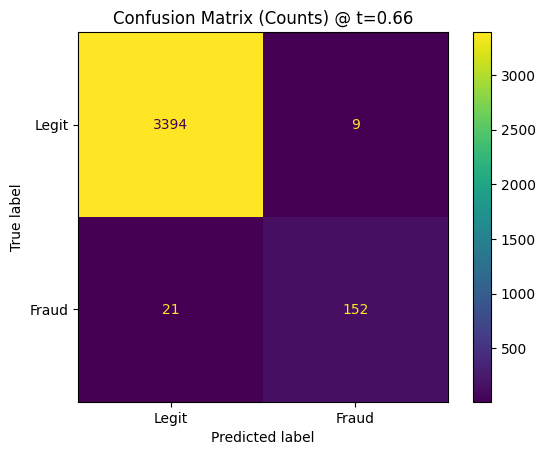

In [20]:
# run eval with your tuned threshold
final_eval = evaluate(model, val_loader, threshold=best_threshold)

from sklearn.metrics import ConfusionMatrixDisplay

y_true = np.asarray(final_eval["labels"]).astype(int)

# use probs if present; otherwise fall back to preds returned by evaluate
if "probs" in final_eval:
    y_pred = (np.asarray(final_eval["probs"]) >= best_threshold).astype(int)
else:
    y_pred = np.asarray(final_eval["preds"]).astype(int)

# counts
cm = confusion_matrix(y_true, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legit","Fraud"])
disp.plot(values_format="d")
plt.title(f"Confusion Matrix (Counts) @ t={best_threshold:.2f}")
plt.show()


AUROC: 0.9887


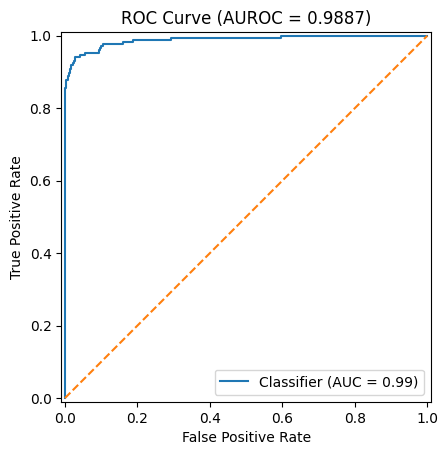

In [21]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# if you don't already have probs in final_eval, re-run evaluate to get them
if "probs" not in final_eval:
    final_eval = evaluate(model, val_loader, threshold=0.5)  # threshold doesn't matter for ROC

y_true = np.asarray(final_eval["labels"]).astype(int)
proba = np.asarray(final_eval["probs"]).astype(float)       # P(class=1)

auroc = roc_auc_score(y_true, proba)
print(f"AUROC: {auroc:.4f}")

# Plot
RocCurveDisplay.from_predictions(y_true, proba)
plt.plot([0, 1], [0, 1], linestyle="--")  # baseline
plt.title(f"ROC Curve (AUROC = {auroc:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [22]:
model.save_pretrained("./model")
tokenizer.save_pretrained("./model")

('./model/tokenizer_config.json',
 './model/special_tokens_map.json',
 './model/vocab.txt',
 './model/added_tokens.json',
 './model/tokenizer.json')

In [23]:
!pip install transformers torch gradio -q

import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import gradio as gr

# Load your trained model (make sure you saved it in ./model)
MODEL_DIR = "./model"   # or change to your path
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
model.eval()

labels = ["Legit", "Fraud"]   # adjust if your order is different

@torch.no_grad()
def predict(text):
    inputs = tokenizer(text, truncation=True, padding=True, max_length=256, return_tensors="pt")
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=-1).squeeze().tolist()
    pred = labels[int(torch.tensor(probs).argmax())]
    return pred, {labels[i]: float(probs[i]) for i in range(len(labels))}

# Simple Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs="text",
    outputs=["label", "json"],
    title="Fake Job Detector",
    description="Paste a job posting to check if it's Legit or Fraud"
)

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://af60c5975328fc603f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
